# Installations

Install and unzip TIMIT dataset from google drive

In [1]:
# ! gdown 15Nq4PdOY7h8AP54ge3EurUPKa91jvezc

In [2]:
# ! unzip timit.zip -d ./timit/

In [101]:
import os
import random
import json
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import IPython.display as ipd
import datasets

import torch
import torch.nn as nn
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor, Wav2Vec2CTCTokenizer, Wav2Vec2Processor
from jiwer import wer


from typing import List, Tuple, Set, Dict
%matplotlib inline

# Dataset

This section contains a modified version of the original function, adapted from [here](https://www.kaggle.com/code/vitouphy/phoneme-recognition-with-wav2vec2/notebook) and [here](https://huggingface.co/blog/fine-tune-wav2vec2-english) to fit our specific task requirements.

In [4]:
timit_path = "./timit/"
timit_data_path = "./timit/data/"

In [5]:
df_train = pd.read_csv(os.path.join(timit_path, 'train_data.csv'))
df_test = pd.read_csv(os.path.join(timit_path, 'test_data.csv'))
df = pd.concat([df_train, df_test])
df = df[df['is_converted_audio'] == False]

In [6]:
df_train = df[df['test_or_train'] == "TRAIN"]
df_test  = df[df['test_or_train'] == "TEST"]

In [7]:
df_train

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
1,2.0,TRAIN,DR4,MMDM0,SI1311.PHN,TRAIN/DR4/MMDM0/SI1311.PHN,TRAIN\\DR4\\MMDM0\\SI1311.PHN,False,False,False,True,False
2,3.0,TRAIN,DR4,MMDM0,SI1311.WRD,TRAIN/DR4/MMDM0/SI1311.WRD,TRAIN\\DR4\\MMDM0\\SI1311.WRD,False,False,True,False,False
3,4.0,TRAIN,DR4,MMDM0,SX321.PHN,TRAIN/DR4/MMDM0/SX321.PHN,TRAIN\\DR4\\MMDM0\\SX321.PHN,False,False,False,True,False
4,5.0,TRAIN,DR4,MMDM0,SX321.WRD,TRAIN/DR4/MMDM0/SX321.WRD,TRAIN\\DR4\\MMDM0\\SX321.WRD,False,False,True,False,False
5,6.0,TRAIN,DR4,MMDM0,SI681.TXT,TRAIN/DR4/MMDM0/SI681.TXT,TRAIN\\DR4\\MMDM0\\SI681.TXT,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
23093,23094.0,TRAIN,DR8,MRDM0,SX245.TXT,TRAIN/DR8/MRDM0/SX245.TXT,TRAIN\\DR8\\MRDM0\\SX245.TXT,False,False,False,NaN,True
23094,23095.0,TRAIN,DR8,MRDM0,SI1044.PHN,TRAIN/DR8/MRDM0/SI1044.PHN,TRAIN\\DR8\\MRDM0\\SI1044.PHN,False,False,False,NaN,False
23096,23097.0,TRAIN,DR8,MRDM0,SX245.WAV,TRAIN/DR8/MRDM0/SX245.WAV,TRAIN\\DR8\\MRDM0\\SX245.WAV,False,True,False,NaN,False
23098,23099.0,TRAIN,DR8,MRDM0,SX335.WAV,TRAIN/DR8/MRDM0/SX335.WAV,TRAIN\\DR8\\MRDM0\\SX335.WAV,False,True,False,NaN,False


In [8]:
df_test

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
0,1.0,TEST,DR4,MGMM0,SX139.WAV,TEST/DR4/MGMM0/SX139.WAV,TEST\\DR4\\MGMM0\\SX139.WAV,False,True,False,False,False
2,3.0,TEST,DR4,MGMM0,SX139.TXT,TEST/DR4/MGMM0/SX139.TXT,TEST\\DR4\\MGMM0\\SX139.TXT,False,False,False,False,True
3,4.0,TEST,DR4,MGMM0,SI499.WRD,TEST/DR4/MGMM0/SI499.WRD,TEST\\DR4\\MGMM0\\SI499.WRD,False,False,True,False,False
4,5.0,TEST,DR4,MGMM0,SX319.WRD,TEST/DR4/MGMM0/SX319.WRD,TEST\\DR4\\MGMM0\\SX319.WRD,False,False,True,False,False
5,6.0,TEST,DR4,MGMM0,SX319.PHN,TEST/DR4/MGMM0/SX319.PHN,TEST\\DR4\\MGMM0\\SX319.PHN,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8394,8395.0,TEST,DR8,MPAM0,SX19.WAV,TEST/DR8/MPAM0/SX19.WAV,TEST\\DR8\\MPAM0\\SX19.WAV,False,True,False,False,False
8395,8396.0,TEST,DR8,MPAM0,SX109.TXT,TEST/DR8/MPAM0/SX109.TXT,TEST\\DR8\\MPAM0\\SX109.TXT,False,False,False,False,True
8397,8398.0,TEST,DR8,MPAM0,SX289.WRD,TEST/DR8/MPAM0/SX289.WRD,TEST\\DR8\\MPAM0\\SX289.WRD,False,False,True,False,False
8398,8399.0,TEST,DR8,MPAM0,SX109.WAV,TEST/DR8/MPAM0/SX109.WAV,TEST\\DR8\\MPAM0\\SX109.WAV,False,True,False,False,False


In this part, we will process the raw data to structure the dataset into three columns:

1. Path to the audio file
2. Text from the audio
3. Corresponding phonemes

Additionally, we will filter out any samples lacking phoneme data, as they cannot be used for training or testing without labels.

In [9]:
PHONETIC_KEY: str = "phonetic"
AUDIO_KEY:    str = "audio"
WORD_KEY:     str = "word"


def convert_phon61_to_phon39(sentence: str) -> str:
    phon61_map39 = {
        'iy':'iy',  'ih':'ih',  'eh':'eh',  'ae':'ae',   'ix':'ih',  'ax':'ah',  'ah':'ah',   'uw':'uw',
        'ux':'uw',  'uh':'uh',  'ao':'aa',  'aa':'aa',   'ey':'ey',  'ay':'ay',  'oy':'oy',   'aw':'aw',
        'ow':'ow',  'l':'l',    'el':'l',   'r':'r',     'y':'y',    'w':'w',    'er':'er',   'axr':'er',
        'm':'m',    'em':'m',   'n':'n',    'nx':'n',    'en':'n',   'ng':'ng',  'eng':'ng',  'ch':'ch',
        'jh':'jh',  'dh':'dh',  'b':'b',    'd':'d',     'dx':'dx',  'g':'g',    'p':'p',     't':'t',
        'k':'k',    'z':'z',    'zh':'sh',  'v':'v',     'f':'f',    'th':'th',  's':'s',     'sh':'sh',
        'hh':'hh',  'hv':'hh',  'pcl':'h#', 'tcl':'h#',  'kcl':'h#', 'qcl':'h#', 'bcl':'h#',  'dcl':'h#',
        'gcl':'h#', 'h#':'h#',  '#h':'h#',  'pau':'h#',  'epi':'h#', 'nx':'n',   'ax-h':'ah', 'q':'h#'
    }
    tokens = [phon61_map39[x] for x in sentence.split()]
    return " ".join(tokens)


def read_text_file(filepath: str) -> str:
    with open(filepath) as f:
        tokens = [line.split()[-1] for line in f]
        return " ".join(tokens)


def merge_item_data(df: pd.DataFrame) -> Dict[str, Dict[str, str]]:
    data = {}

    for _, row in tqdm(df.iterrows()):
        path = row['path_from_data_dir']
        entry_id = path.split('.')[0]
        entry_id = "-".join(entry_id.split('/')[-2:])

        if entry_id not in data:
            data[entry_id] = {}

        if row['is_audio'] is True:
            data[entry_id][AUDIO_KEY] = os.path.join(timit_data_path, path)
        elif row['is_word_file'] is True:
            data[entry_id][WORD_KEY] = read_text_file(os.path.join(timit_data_path, path))
        elif row['is_phonetic_file'] is True:
            phoneme_sentence = read_text_file(os.path.join(timit_data_path, path))
            data[entry_id][PHONETIC_KEY] = convert_phon61_to_phon39(phoneme_sentence)
    return data


def transform_dataset(df: pd.DataFrame) -> Dict[str, List[str]]:
    merged_data = merge_item_data(df)

    phonetic_files: List[str] = []
    audio_files:    List[str] = []
    word_files:     List[str] = []
    keys_set:       Set[str]  = set([PHONETIC_KEY, AUDIO_KEY, WORD_KEY])

    for _, value in merged_data.items():
        if set(value) == keys_set:
            phonetic_files.append(value[PHONETIC_KEY])
            audio_files.append(value[AUDIO_KEY])
            word_files.append(value[WORD_KEY])

    return {
        AUDIO_KEY: audio_files,
        WORD_KEY: word_files,
        PHONETIC_KEY: phonetic_files
    }

In [10]:
train_val = transform_dataset(df_train)
test = transform_dataset(df_test)

18480it [00:01, 13174.88it/s]
6720it [00:00, 10972.67it/s]


In [11]:
random.seed(42)
n = len(train_val[AUDIO_KEY])
train_n = int(n * 0.9)
val_n = n - train_n

val_ind = np.array(sorted(random.sample(range(0, n), val_n)))
train_ind = np.array(sorted(list(set(range(0, n)) - set(val_ind))))

In [12]:
train = dict()
val = dict()

for key in [AUDIO_KEY, WORD_KEY, PHONETIC_KEY]:
    train[key] = np.array(train_val[key])[train_ind].tolist()
    val[key]   = np.array(train_val[key])[val_ind].tolist()

In [13]:
print(f"Train set length: {len(train[AUDIO_KEY])}")
print(f"Validation set length: {len(val[AUDIO_KEY])}")
print(f"Test set length: {len(test[AUDIO_KEY])}")

Train set length: 1512
Validation set length: 168
Test set length: 1680


Now let's convert the data to a data type that the model will work with.

In [14]:
train_dataset = datasets.Dataset.from_dict(train)
val_dataset   = datasets.Dataset.from_dict(val)
test_dataset  = datasets.Dataset.from_dict(test)

In [15]:
train_dataset = train_dataset.cast_column(AUDIO_KEY, datasets.Audio(sampling_rate=16_000))
val_dataset   = val_dataset.cast_column(AUDIO_KEY, datasets.Audio(sampling_rate=16_000))
test_dataset  = test_dataset.cast_column(AUDIO_KEY, datasets.Audio(sampling_rate=16_000))

In [16]:
ind = 10

print("Text:", train_dataset[ind][WORD_KEY])
print("Phonetics:", train_dataset[ind][PHONETIC_KEY])
print("Input array shape:", train_dataset[ind][AUDIO_KEY]["array"].shape)
print("Sampling rate:", train_dataset[ind][AUDIO_KEY]["sampling_rate"])
ipd.Audio(data=train_dataset[ind][AUDIO_KEY]["array"], autoplay=False, rate=16000)

Text: get a calico cat to keep
Phonetics: h# g ih dx ih h# k ae l ih h# k ow h# k ae h# t ah h# k iy h# p h#
Input array shape: (32359,)
Sampling rate: 16000


#### Phonemes vocabulary

In [17]:
train_phonetics = [phone for x in train_dataset for phone in x[PHONETIC_KEY].split()]
val_phonetics   = [phone for x in val_dataset for phone in x[PHONETIC_KEY].split()]
test_phonetics  = [phone for x in test_dataset for phone in x[PHONETIC_KEY].split()]

In [18]:
vocab_list = list(set(train_phonetics) | set(val_phonetics) | set(test_phonetics) | set([' ']))

vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
print(vocab_dict)

{' ': 0, 'aa': 1, 'ae': 2, 'ah': 3, 'aw': 4, 'ay': 5, 'b': 6, 'ch': 7, 'd': 8, 'dh': 9, 'dx': 10, 'eh': 11, 'er': 12, 'ey': 13, 'f': 14, 'g': 15, 'h#': 16, 'hh': 17, 'ih': 18, 'iy': 19, 'jh': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'ng': 25, 'ow': 26, 'oy': 27, 'p': 28, 'r': 29, 's': 30, 'sh': 31, 't': 32, 'th': 33, 'uh': 34, 'uw': 35, 'v': 36, 'w': 37, 'y': 38, 'z': 39}


In [19]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
print(len(vocab_dict))

42


In [20]:
with open('./vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [21]:
del df
del df_test
del df_train

# Modeling

### Wav2Vec2 

In [22]:
DEVICE = "cuda"

ssl_model_name = "facebook/wav2vec2-base-960h"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(ssl_model_name)
tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

ssl_model = Wav2Vec2Model.from_pretrained(ssl_model_name, output_hidden_states=True).to(DEVICE)
ssl_model.eval()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [23]:
ind: int = 0
inputs = processor(train_dataset['audio'][ind]['array'], 
                   sampling_rate=train_dataset['audio'][ind]['sampling_rate'], 
                   return_tensors="pt", 
                   padding=True).input_values.to(DEVICE)

with torch.no_grad():
    outputs = ssl_model(inputs)

hidden_states = outputs.hidden_states
for i, hs in enumerate(hidden_states):
    print(f"Layer {i}: {hs.shape}")

Layer 0: torch.Size([1, 270, 768])
Layer 1: torch.Size([1, 270, 768])
Layer 2: torch.Size([1, 270, 768])
Layer 3: torch.Size([1, 270, 768])
Layer 4: torch.Size([1, 270, 768])
Layer 5: torch.Size([1, 270, 768])
Layer 6: torch.Size([1, 270, 768])
Layer 7: torch.Size([1, 270, 768])
Layer 8: torch.Size([1, 270, 768])
Layer 9: torch.Size([1, 270, 768])
Layer 10: torch.Size([1, 270, 768])
Layer 11: torch.Size([1, 270, 768])
Layer 12: torch.Size([1, 270, 768])


In [24]:
from torch.utils.data import DataLoader, Dataset

class PhonemeDataset(Dataset):
    def __init__(self, data: datasets.Dataset, layer: int, save_extra_data: bool = False):
        self.data = []
        self.extra_data = []

        print("Preprocessing data...")
        for audio, phonetic in tqdm(zip(data[AUDIO_KEY], data[PHONETIC_KEY])):
            input = processor(audio["array"], 
                              sampling_rate=audio["sampling_rate"], 
                              return_tensors="pt", 
                              padding=True).input_values.to(DEVICE)
            with torch.no_grad():
                outputs = ssl_model(input)
            features = outputs.hidden_states[-layer].cpu()

            with processor.as_target_processor():
                labels = processor(phonetic).input_ids

            self.data.append({
                'features': features[0],
                'labels': torch.tensor(labels)
            })

        if save_extra_data:
            print("Saving extra data...")
            for audio, words, phonetic in tqdm(zip(data[AUDIO_KEY], data[WORD_KEY], data[PHONETIC_KEY])):
                self.extra_data.append({
                    AUDIO_KEY: audio,
                    WORD_KEY: words,
                    PHONETIC_KEY: phonetic
                })

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        return self.data[idx]


    def get_extra_data(self, idx: int) -> Dict:
        if len(self.extra_data) == 0:
            raise ValueError("Extra data is missing")
        return self.extra_data[idx]

In [25]:
train_dataset_sc = PhonemeDataset(train_dataset, 1)
val_dataset_sc   = PhonemeDataset(val_dataset, 1)
test_dataset_sc  = PhonemeDataset(test_dataset, 1, save_extra_data=True)

Preprocessing data...


0it [00:00, ?it/s]/home/artur/files/Audio Processing/phoneme_recognition/venv/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
1512it [00:34, 44.31it/s]


Preprocessing data...


168it [00:03, 44.34it/s]


Preprocessing data...


1680it [00:38, 43.96it/s]


Saving extra data...


1680it [00:00, 1330017.12it/s]


### Heads

In [26]:
class LinearHead(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)


    def forward(self, x):
        return self.fc(x)



class MLPHead(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, dropout_prob: float, output_dim: int):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x



class ReccurentHead(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int, output_dim: int, model_type: str = "GRU"):
        super().__init__()
        if model_type == "GRU":
            self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            raise ValueError("Model type must be GRU or LSTM")
        
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        x, _ = self.rnn(x)
        return self.fc(x)



class ConvHead(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, channels: int, kernel_size: int = 3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, 
                               out_channels=channels, 
                               kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.conv2 = nn.Conv1d(in_channels=channels, 
                               out_channels=output_dim, 
                               kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = x.permute(0, 2, 1) #(BATCH, FEATURES, SEQ)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x.permute(0, 2, 1) #(BATCH, SEQ, FEATURES)



class AttentionHead(nn.Module):
    def __init__(self, input_dim: int, num_heads: int, output_dim: int):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads, batch_first=True)
        self.fc = nn.Linear(input_dim, output_dim)


    def forward(self, x):
        x, _ = self.attn(x, x, x)
        return self.fc(x)

### Utils

In [27]:
def data_collator(batch: List[Dict[str, torch.tensor]]):    
    features = [sample['features'] for sample in batch]
    labels   = [sample['labels'] for sample in batch]
    padded_features = torch.nn.utils.rnn.pad_sequence(features, batch_first=True)

    labels_length = torch.tensor([len(label) for label in labels], dtype=torch.long)
    labels = torch.cat([label.clone().detach().long() for label in labels])
    return padded_features, labels, labels_length

In [28]:
def predict_phonemes(model: nn.Module, features: torch.Tensor, reversed_vocab_dict: Dict[int, str], ctc_blank: int) -> str:
    features = features.to(DEVICE)

    with torch.no_grad():
        logits = model(features).cpu()

    probs = torch.softmax(logits, dim=-1)
    preds = torch.argmax(probs, dim=-1).squeeze().numpy()

    merged = [preds[0]]
    for pred in preds:
        if pred != merged[-1]:
            merged.append(pred)
    
    result = []
    for val in merged:
        if val != ctc_blank and val in reversed_vocab_dict:
            result.append(reversed_vocab_dict[val])

    return " ".join(result)


def show_results(model: nn.Module, dataset: PhonemeDataset, idx: int, reversed_vocab_dict: Dict[int, str], ctc_blank: int) -> List[float]:
    data = dataset.get_extra_data(idx)
    text = data[WORD_KEY]
    phonetics = data[PHONETIC_KEY]
    audio = data[AUDIO_KEY]["array"]
    
    features, _, _ = data_collator([dataset[idx]])
    features = features.to(DEVICE)
    prediction = predict_phonemes(model, features, reversed_vocab_dict, ctc_blank)
    
    print(f"Text: {text}")
    print(f"PER: {wer(reference=phonetics, hypothesis=prediction)}")
    print(f"Predicted phonetics:\n{phonetics}")
    print(f"Ground Truth phonetics:\n{prediction}")
    return audio

In [29]:
def train_epoch(model: nn.Module, train_loader: DataLoader, criterion: nn.Module, optimizer: torch.optim, disable_tqdm: bool = False) -> float:
    train_loss = 0.0

    model.train()
    for features, labels, labels_lengths in tqdm(train_loader, disable=disable_tqdm):
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)
        labels_lengths = labels_lengths.to(DEVICE)

        optimizer.zero_grad()
        logits = model(features)
        log_probs = torch.log_softmax(logits, dim=-1).permute(1, 0, 2) #(SEQ, BATCH, CLASSES)

        input_lengths = torch.full(
            size=(logits.size(0),), 
            fill_value=logits.size(1), 
            dtype=torch.long,
            device=DEVICE
        )
        
        loss = criterion(log_probs, labels, input_lengths, labels_lengths)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    return train_loss / len(train_loader)


def evaluate_model(model: nn.Module, val_loader: DataLoader, reversed_vocab_dict: Dict, ctc_blank: int, disable_tqdm: bool = False) -> float:
    total_per = 0.0

    model.eval()
    for features, labels, _ in tqdm(val_loader, disable=disable_tqdm):
        expected = []
        for val in labels.numpy():
            if val in reversed_vocab_dict:
                expected.append(reversed_vocab_dict[val])
        ground_truth = " ".join(expected)

        predicted = predict_phonemes(model, features, reversed_vocab_dict, ctc_blank)
        total_per += wer(ground_truth, predicted)
    return total_per / len(val_loader)


def train_model(model: nn.Module, 
                train_loader: DataLoader, 
                val_loader: DataLoader, 
                criterion: nn.Module, 
                optimizer: torch.optim, 
                reversed_vocab_dict: Dict, 
                ctc_blank: int,
                weights_path: str,
                num_epochs: int = 100,
                best_per: float = 1,
                disable_tqdm: bool = False) -> Tuple[float, float]:

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion=criterion, optimizer=optimizer, disable_tqdm=disable_tqdm)
        val_per = evaluate_model(model, val_loader, reversed_vocab_dict, ctc_blank, disable_tqdm=disable_tqdm)
        if best_per - val_per > 0.001:
            torch.save(model.state_dict(), weights_path)
            best_per = val_per
        if not disable_tqdm:
            print(f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Train Loss: {train_loss}, "
                f"Validation PER: {val_per:.4f}")
    return train_loss, best_per

In [30]:
reversed_vocab_dict = dict()

for key in vocab_dict:
    reversed_vocab_dict[vocab_dict[key]] = key 

### Training

In [ ]:
# ! mkdir weights
# ! mkdir weights/wav2vec2

In [47]:
classes = len(vocab_dict) + 1
input_dim = 768
batch_size = 1
ctc_blank = len(vocab_dict)

model = MLPHead(input_dim=input_dim, 
                hidden_dim=512,
                dropout_prob=0.5,
                output_dim=classes).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
ctc_loss = nn.CTCLoss(blank=ctc_blank)
train_loader = DataLoader(train_dataset_sc, collate_fn=data_collator, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset_sc, collate_fn=data_collator, batch_size=1)
test_loader  = DataLoader(test_dataset_sc, collate_fn=data_collator, batch_size=1)

In [48]:
train_loss, best_val_per = train_model(model=model, 
                                       train_loader=train_loader, 
                                       val_loader=val_loader, 
                                       criterion=ctc_loss, 
                                       optimizer=optimizer, 
                                       reversed_vocab_dict=reversed_vocab_dict, 
                                       ctc_blank=ctc_blank, 
                                       num_epochs=10,
                                       weights_path="./weights/wav2vec2/mlp.pt")

test_per = evaluate_model(model=model,
                          val_loader=test_loader,
                          reversed_vocab_dict=reversed_vocab_dict,
                          ctc_blank=ctc_blank)

print(f"\nFinal loss: {train_loss}")
print(f"Best validation PER: {best_val_per}")
print(f"Test PER: {test_per}")

100%|██████████| 168/168 [00:00<00:00, 1213.16it/s]


Epoch [1/10], Train Loss: 2.3513651707815746, Validation PER: 0.4664


100%|██████████| 168/168 [00:00<00:00, 1091.06it/s]


Epoch [2/10], Train Loss: 1.3338527707038101, Validation PER: 0.3939


100%|██████████| 168/168 [00:00<00:00, 1283.24it/s]


Epoch [3/10], Train Loss: 1.1599136475453933, Validation PER: 0.3588


100%|██████████| 168/168 [00:00<00:00, 1241.93it/s]


Epoch [4/10], Train Loss: 1.0535364928581412, Validation PER: 0.3191


100%|██████████| 168/168 [00:00<00:00, 1200.94it/s]


Epoch [5/10], Train Loss: 0.984139407319682, Validation PER: 0.3198


100%|██████████| 168/168 [00:00<00:00, 1085.21it/s]


Epoch [6/10], Train Loss: 0.9325342021448902, Validation PER: 0.2833


100%|██████████| 168/168 [00:00<00:00, 1389.72it/s]


Epoch [7/10], Train Loss: 0.8929147423102112, Validation PER: 0.2767


100%|██████████| 168/168 [00:00<00:00, 1341.64it/s]


Epoch [8/10], Train Loss: 0.8559173747857727, Validation PER: 0.2678


100%|██████████| 168/168 [00:00<00:00, 1284.16it/s]


Epoch [9/10], Train Loss: 0.8263448680499716, Validation PER: 0.2591


100%|██████████| 168/168 [00:00<00:00, 1405.25it/s]


Epoch [10/10], Train Loss: 0.8010763580166789, Validation PER: 0.2549


100%|██████████| 1680/1680 [00:01<00:00, 1393.57it/s]


Final loss: 0.8010763580166789
Best validation PER: 0.25489765752847804
Test PER: 0.2537624005189562


In [49]:
idx = 10
ipd.Audio(data=show_results(model, test_dataset_sc, idx, reversed_vocab_dict, 42), autoplay=False, rate=16000)

Text: this brochure is particularly informative for prospective buyer
PER: 0.3829787234042553
Predicted phonetics:
h# dh ih s h# b r ow sh er ih s h# p ah h# t ih h# k l ih n f ow m h# t ih f er h# p er s h# p ah h# t ih v h# b ay er h#
Ground Truth phonetics:
dh ih s h# b | r ow s sh uw er s h# p dx ih h# k ih n f aa er m dx ih v f aa h# p er s h# p eh h# t ih v h# b aa h#


# Testing

In [ ]:
classes = len(vocab_dict) + 1
input_dim = 768
batch_size = 1
ctc_blank = len(vocab_dict)

models: List[nn.Module] = [LinearHead, MLPHead, ReccurentHead, ReccurentHead, ConvHead, AttentionHead]
model_name = ["Linear", "MLP", "GRU", "LSTM", "Conv", "Attention"]
parameters = [
    (input_dim, classes),                  #Linear: (input_dim, output_dim)
    (input_dim, 512, 0.5, classes),        #MLP: (input_dim, hidden_dim, dropout_prob, output_dim)
    (input_dim, 256, 2, classes, "GRU"),   #GRU: (input_dim, hidden_dim, num_layers, output_dim, model_type)
    (input_dim, 256, 2, classes, "LSTM"),  #LSTM: (input_dim, hidden_dim, num_layers, output_dim, model_type)
    (input_dim, classes, 256, 3),          #Conv: (input_dim, output_dim, channels, kernel_size)
    (input_dim, 4, classes)                #Attention: (input_dim, num_heads, output_dim)
]
weights_path = [
    "./weights/wav2vec2/linear.pt",
    "./weights/wav2vec2/mlp.pt",
    "./weights/wav2vec2/gru.pt",
    "./weights/wav2vec2/lstm.pt",
    "./weights/wav2vec2/conv.pt",
    "./weights/wav2vec2/attention.pt"
]
best_PER = [1.0 for _ in range(len(models))]
num_epochs =  [100, 200, 100, 100, 100, 100]
batch_sizes = [1, 4, 8, 8, 8, 8]

In [58]:
val_PER_per_layer:  List[List[float]] = []
test_PER_per_layer: List[List[float]] = []
num_layers = 2

for layer in range(1, num_layers + 1):
    print(f"--------------------Layer {layer}--------------------")
    val_PER_list = []
    test_PER_list = []
    train_dataset_ly = PhonemeDataset(train_dataset, layer)
    val_dataset_ly   = PhonemeDataset(val_dataset, layer)
    test_dataset_ly  = PhonemeDataset(test_dataset, layer)

    val_loader   = DataLoader(val_dataset_ly, collate_fn=data_collator, batch_size=1)
    test_loader  = DataLoader(test_dataset_ly, collate_fn=data_collator, batch_size=1)

    for model_idx in range(len(models)):
        model = models[model_idx](*parameters[model_idx]).to(DEVICE)
        batch_size = batch_sizes[model_idx]

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        ctc_loss = nn.CTCLoss(blank=ctc_blank)
        train_loader = DataLoader(train_dataset_ly, collate_fn=data_collator, batch_size=batch_size, shuffle=True)

        train_loss, best_val_PER = train_model(model=model, 
                                               train_loader=train_loader, 
                                               val_loader=val_loader, 
                                               criterion=ctc_loss, 
                                               optimizer=optimizer, 
                                               reversed_vocab_dict=reversed_vocab_dict, 
                                               ctc_blank=ctc_blank, 
                                               best_per=best_PER[model_idx],
                                               num_epochs=num_epochs[model_idx],
                                               weights_path=weights_path[model_idx],
                                               disable_tqdm=True)

        best_PER[model_idx] = max(best_PER[model_idx], best_val_PER)
        test_PER = evaluate_model(model=model,
                                  val_loader=test_loader,
                                  reversed_vocab_dict=reversed_vocab_dict,
                                  ctc_blank=ctc_blank,
                                  disable_tqdm=True)

        print(f"{model_name[model_idx]}. Train loss: {train_loss}, Best Validation PER: {best_val_PER}, Test PER: {test_PER}")
        val_PER_list.append(best_val_PER)
        test_PER_list.append(test_PER)
    
    val_PER_per_layer.append(val_PER_list)
    test_PER_per_layer.append(test_PER_list)

--------------------Layer 1--------------------
Preprocessing data...


1512it [00:34, 43.46it/s]


Preprocessing data...


168it [00:03, 43.67it/s]


Preprocessing data...


1680it [00:38, 43.56it/s]


Linear. Train loss: 0.632957270901118, Best Validation PER: 0.23738768139032662, Test PER: 0.2446950178896953
MLP. Train loss: 0.3568276240239068, Best Validation PER: 0.14869458863856697, Test PER: 0.15891903178610906
GRU. Train loss: 0.04582738449609784, Best Validation PER: 0.15324918186764008, Test PER: 0.18056499963322487
LSTM. Train loss: 0.05000426956309528, Best Validation PER: 0.1573816772262228, Test PER: 0.18208651299770254
Conv. Train loss: 0.277546326555903, Best Validation PER: 0.1808399026917767, Test PER: 0.18865598809183526
Attention. Train loss: 0.4952191391949931, Best Validation PER: 0.21704005440143123, Test PER: 0.22752523664041294
--------------------Layer 2--------------------
Preprocessing data...


1512it [00:32, 46.17it/s]


Preprocessing data...


168it [00:03, 46.03it/s]


Preprocessing data...


1680it [00:38, 43.70it/s]


Linear. Train loss: 0.3884259847204679, Best Validation PER: 0.15741781868230734, Test PER: 0.16001569936819443
MLP. Train loss: 0.23224217326395094, Best Validation PER: 0.1245361342898821, Test PER: 0.13090261105473341
GRU. Train loss: 0.0702539613795659, Best Validation PER: 0.1284781663649499, Test PER: 0.1366313544140786
LSTM. Train loss: 0.11322774505489087, Best Validation PER: 0.12916729693522783, Test PER: 0.13649680489720203
Conv. Train loss: 0.23083535223095505, Best Validation PER: 0.1327998090110578, Test PER: 0.15356433590155852
Attention. Train loss: 0.30155650009869267, Best Validation PER: 0.18743856569994863, Test PER: 0.21206043194709356


# Results

In [102]:
def plot_layer_accuracy_hist(val_acc: np.ndarray, test_acc: np.ndarray, head_idx: int, models: List[str], ssl_model: str) -> None:
    layers = np.arange(len(val_acc)) + 1

    plt.figure(figsize=(8, 5))
    width = 0.4
    
    plt.bar(layers - width/2, val_acc[:, head_idx], width=width, label="Validation PER", alpha=0.7)
    plt.bar(layers + width/2, test_acc[:, head_idx], width=width, label="Test PER", alpha=0.7)

    plt.xlabel(f"{ssl_model} Layer")
    plt.ylabel("PER")
    plt.title(f"{ssl_model} Layer PER Distribution for {models[head_idx]} head")
    plt.xticks(layers)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


def plot_model_accuracy_hist(val_acc: np.ndarray, test_acc: np.ndarray, layer_idx: int, models: List[str], ssl_model: str) -> None:
    models_idx = np.arange(len(models)) 

    plt.figure(figsize=(8, 5))
    width = 0.4

    plt.bar(models_idx - width/2, val_acc[layer_idx], width=width, label="Validation PER", alpha=0.7)
    plt.bar(models_idx + width/2, test_acc[layer_idx], width=width, label="Test PER", alpha=0.7)

    plt.xlabel("Heads")
    plt.ylabel("PER")
    plt.title(f"Head PER Distribution for {ssl_model} Layer {layer_idx + 1}")
    plt.xticks(models_idx, models, rotation=45)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


def plot_best_layers_hist(val_acc: np.ndarray, test_acc: np.ndarray, models: List[str], ssl_model: str) -> None:
    best_layers = np.argmin(val_acc, axis=0)
    best_val_acc = val_acc[best_layers, np.arange(len(best_layers))]
    best_test_acc = test_acc[best_layers, np.arange(len(best_layers))]

    models_idx = np.arange(len(models))

    plt.figure(figsize=(8, 5))
    width = 0.4

    plt.bar(models_idx - width/2, best_val_acc, width=width, label="Validation PER", alpha=0.7)
    plt.bar(models_idx + width/2, best_test_acc, width=width, label="Test PER", alpha=0.7)

    for i, layer in enumerate(best_layers):
        plt.text(i, best_val_acc[i] + 0.005, f"L{layer + 1}", ha='center', fontsize=10, color='blue')

    plt.xlabel("Heads")
    plt.ylabel("PER")
    plt.title(f"Best {ssl_model} Layer PER Across Heads")
    plt.xticks(models_idx, models, rotation=45)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

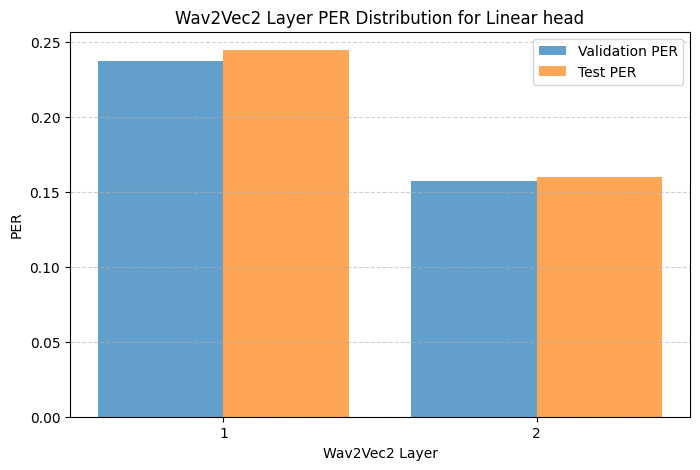

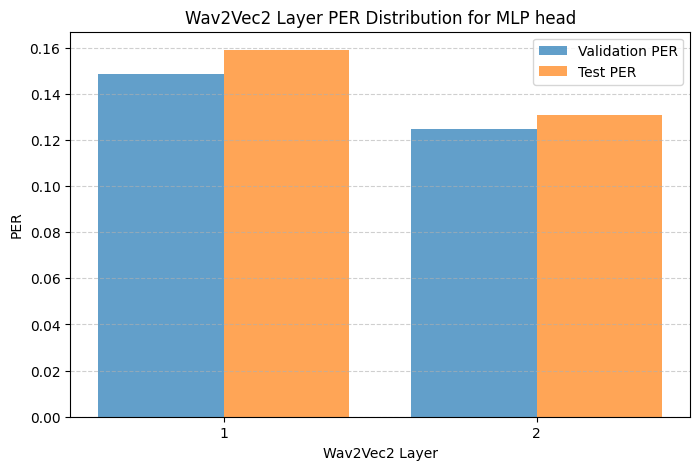

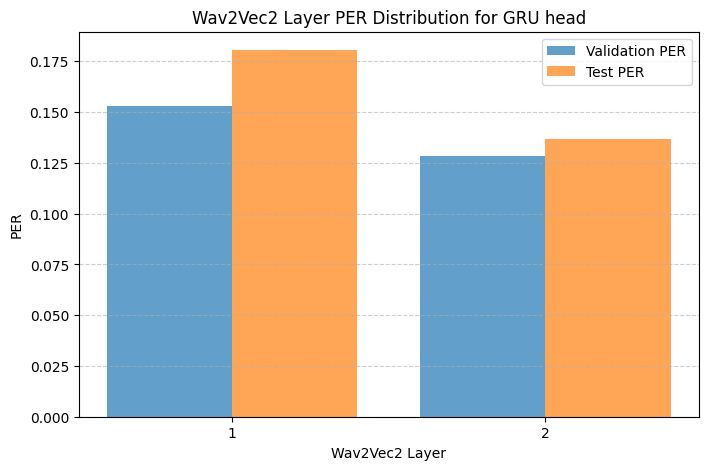

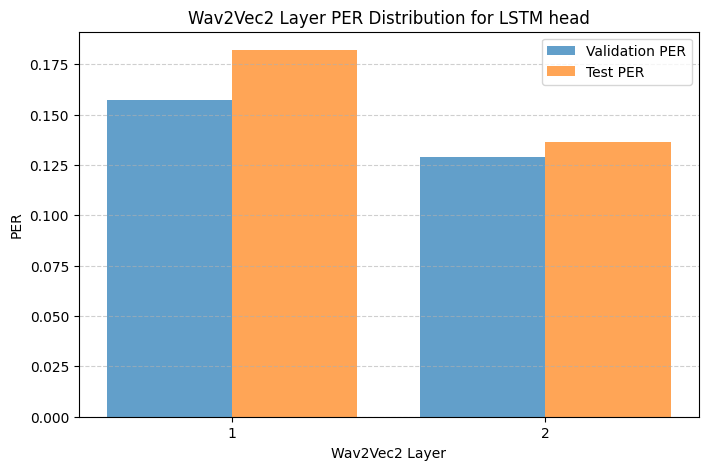

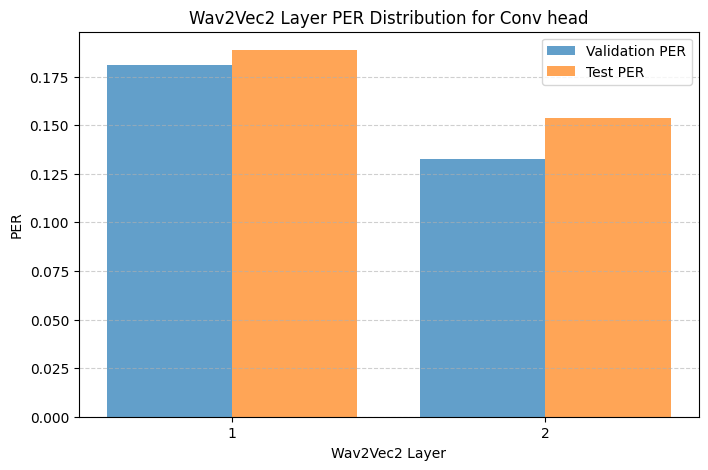

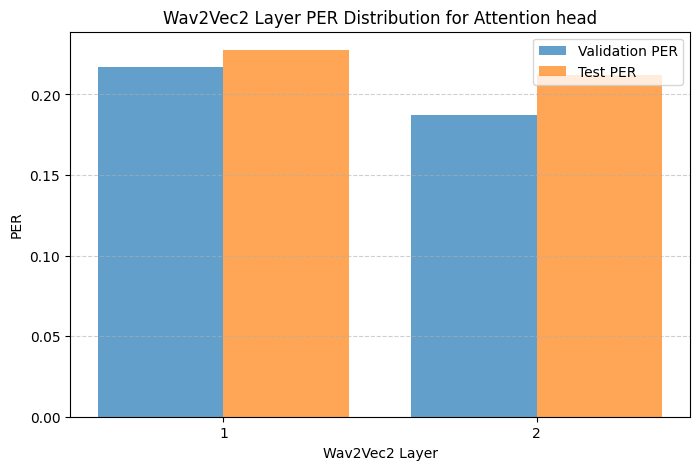

In [103]:
for i in range(len(model_name)):
    plot_layer_accuracy_hist(np.array(val_PER_per_layer), np.array(test_PER_per_layer), head_idx=i, models=model_name, ssl_model="Wav2Vec2")

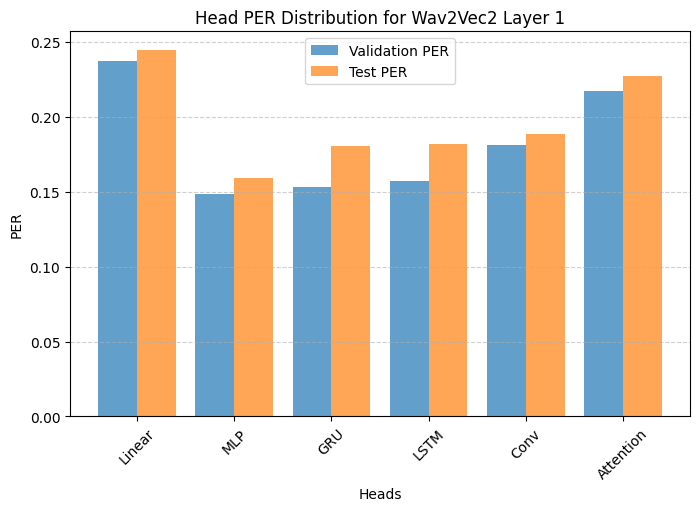

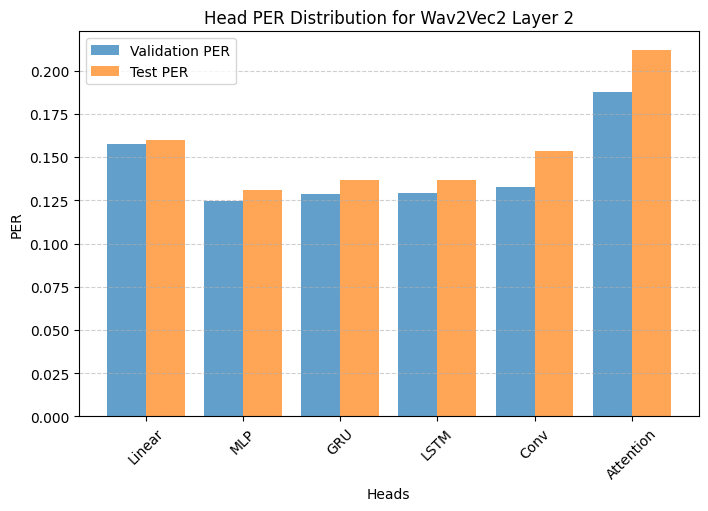

In [104]:
for i in range(num_layers):
    plot_model_accuracy_hist(np.array(val_PER_per_layer), np.array(test_PER_per_layer), layer_idx=i, models=model_name, ssl_model="Wav2Vec2")

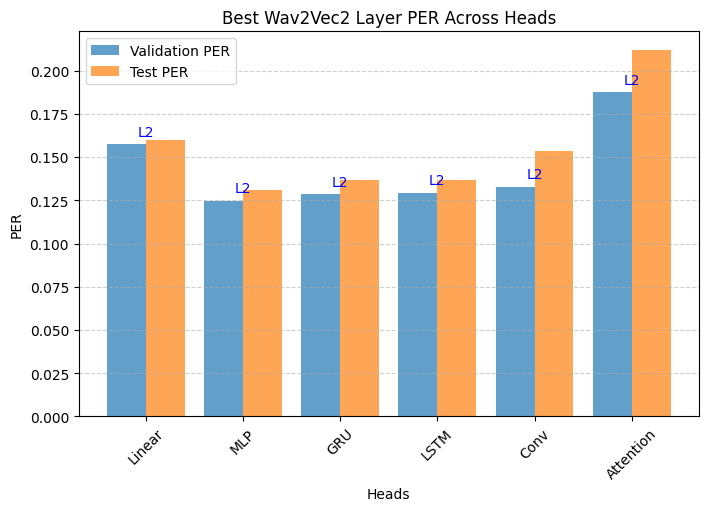

In [105]:
plot_best_layers_hist(np.array(val_PER_per_layer), np.array(test_PER_per_layer), models=model_name, ssl_model="Wav2Vec2")